In [46]:
import torch 
import pandas as pd 
import torch.nn as nn 
from torch.utils.data import random_split, DataLoader, TensorDataset 
import numpy as np 
import torch.optim as optim 

In [47]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
iris = fetch_ucirepo(id=53) 
  
# data (as pandas dataframes) 
x_data = iris.data.features 
y_data = iris.data.targets 

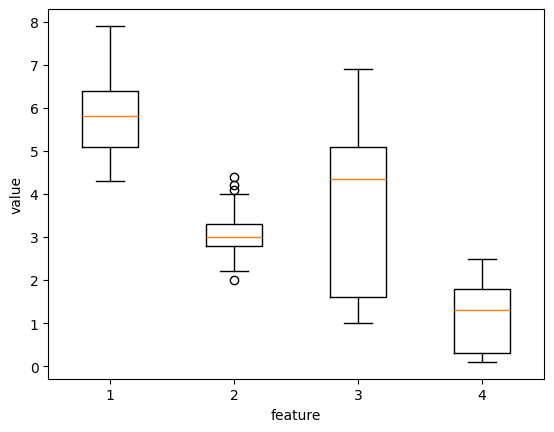

In [48]:
import matplotlib.pyplot as plt

plt.boxplot(x_data)
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

In [53]:
x_data

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [50]:
y_data.value_counts()

class          
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

In [51]:
class_index = {'Iris-setosa' : 0, 'Iris-versicolor' : 1, 'Iris-virginica' : 2}
y_data['class_index'] = y_data['class'].map(class_index)
y_data.drop('class', axis=1, inplace=True)
y_data

C:\Users\HKIT\AppData\Local\Temp\ipykernel_11600\1670497242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_data['class_index'] = y_data['class'].map(class_index)
C:\Users\HKIT\AppData\Local\Temp\ipykernel_11600\1670497242.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_data.drop('class', axis=1, inplace=True)


,class_index
0,0
1,0
2,0
3,0
4,0
...,...
145,2
146,2
147,2
148,2


In [52]:
x = torch.tensor(x_data.to_numpy(), dtype=torch.float32)
print('Input format: ', x.shape, x.dtype)
y = torch.tensor(y_data.to_numpy(), dtype=torch.int64) 
print('Output format: ', y.shape, y.dtype)

Input format:  torch.Size([150, 4]) torch.float32
Output format:  torch.Size([150, 1]) torch.int64


In [54]:
dataset = TensorDataset(x, y)

In [55]:
dataset_size = len(dataset)
dataset_size

150

In [56]:
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size  
 
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

# Create Dataloader to read the data within batch sizes and put into memory. 
train_loader = DataLoader(train_dataset, batch_size = 10, shuffle = True) 
validate_loader = DataLoader(valid_dataset, batch_size = 1) 
test_loader = DataLoader(test_dataset, batch_size = 1)

In [57]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(x.shape[1], 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [58]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [59]:
model = Model().to(device)

In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [61]:
from tqdm import tqdm

for epoch in tqdm(range(3)):
    cost = 0.0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device).squeeze(dim=-1)

        output = model(x)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss

    cost = cost / len(train_loader)

100%|██████████| 3/3 [00:00<00:00, 16.34it/s]


In [62]:
model.eval()

Model(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=3, bias=True)
    (5): Softmax(dim=1)
  )
)

In [63]:
with torch.no_grad():
    for x, y in validate_loader:
        x = x.to(device)
        y = y.to(device)
        print(x)
        output = model(x)

        _, predicted = torch.max(output, 1)
        print(predicted.item(), y.item())


tensor([[6.3000, 3.3000, 6.0000, 2.5000]])
1 2
tensor([[6.3000, 2.5000, 4.9000, 1.5000]])
1 1
tensor([[5.9000, 3.2000, 4.8000, 1.8000]])
1 1
tensor([[5.1000, 3.3000, 1.7000, 0.5000]])
0 0
tensor([[4.9000, 2.5000, 4.5000, 1.7000]])
1 2
tensor([[5.4000, 3.7000, 1.5000, 0.2000]])
0 0
tensor([[6.1000, 2.8000, 4.7000, 1.2000]])
1 1
tensor([[5.6000, 2.8000, 4.9000, 2.0000]])
1 2
tensor([[6.5000, 3.2000, 5.1000, 2.0000]])
1 2
tensor([[7.2000, 3.2000, 6.0000, 1.8000]])
1 2
tensor([[6.1000, 3.0000, 4.9000, 1.8000]])
1 2
tensor([[7.6000, 3.0000, 6.6000, 2.1000]])
1 2
tensor([[5.0000, 3.4000, 1.5000, 0.2000]])
0 0
tensor([[5.7000, 2.5000, 5.0000, 2.0000]])
1 2
tensor([[5.4000, 3.4000, 1.5000, 0.4000]])
0 0


In [64]:
test_x = [[5, 2, 3, 1.2]]
test_x = torch.tensor(test_x, dtype=torch.float32)
test_x

tensor([[5.0000, 2.0000, 3.0000, 1.2000]])

In [65]:
with torch.no_grad():
    test_x = test_x.to(device)
    output = model(test_x)
    _, predicted = torch.max(output, 1)
    print(predicted.item())

1
